In [ ]:
%pip install transformers
%pip install scikit-learn
%pip install modAL
%pip install datasets
%pip install accelerate -U

In [2]:
import transformers
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import pandas as pd
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification
from transformers import AutoTokenizer
import regex as re
from collections import defaultdict
from IPython.display import display, HTML, clear_output
from matplotlib import pyplot as plt
import csv

/home/rezett/Tese/Thesis/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
# Define the mapping from emotion names to numbers
emotion_mapping = {
    'admiration': 0, 'amusement': 1, 'anger': 2, 'annoyance': 3,
    'approval': 4, 'caring': 5, 'confusion': 6, 'curiosity': 7,
    'desire': 8, 'disappointment': 9, 'disapproval': 10, 'disgust': 11,
    'embarrassment': 12, 'excitement': 13, 'fear': 14, 'gratitude': 15,
    'grief': 16, 'joy': 17, 'love': 18, 'nervousness': 19, 'optimism': 20,
    'pride': 21, 'realization': 22, 'relief': 23, 'remorse': 24, 'sadness': 25,
    'surprise': 26, 'neutral': 27
}

def process_csv(file_path):
    """Processes a single CSV file."""
    df = pd.read_csv(file_path, delimiter=';')

    # Find emotion numbers (same as your existing code)
    emotion_numbers = []
    for index, row in df.iterrows():
        emotion_number = 0
        for emotion, number in emotion_mapping.items():
            if row['emotion'] == emotion:
                emotion_number = number
                break
        emotion_numbers.append(emotion_number)

    # Add emotion numbers as a new column
    df['emotion'] = emotion_numbers

    # Select relevant columns and ensure data types
    new_df = df[['text', 'emotion']]
    new_df['text'] = new_df['text'].astype(str)
    new_df['emotion'] = new_df['emotion'].astype(int)

    return new_df

initial_labeled_data = process_csv('active_learning_emotions.csv')

# Split into training and testing sets
train_df, test_df = train_test_split(initial_labeled_data, test_size=0.2, random_state=42)

/tmp/ipykernel_14894/2805424054.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['text'] = new_df['text'].astype(str)
/tmp/ipykernel_14894/2805424054.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['emotion'] = new_df['emotion'].astype(int)


In [5]:
# Print shapes to verify the split
print("Training Data Shape:", train_df.shape)
print("Testing Data Shape:", test_df.shape)

print(f"Train DF: {train_df}")
print(f"Test DF: {test_df}")

Training Data Shape: (84, 2)
Testing Data Shape: (21, 2)
Train DF:                                                   text  emotion
55    "I am writing to express my frustration with ...        2
22   Noticed something off with your account? We're...        5
76     "Shop now before they're gone: [suspicious l...        0
44   A request to change your password was made, bu...        6
72    "The news of the project's cancellation has l...       25
..                                                 ...      ...
71    "I'm saddened to hear about your recent loss....       25
14   You're almost there! Confirm your details now ...       13
92    "Claim your exclusive discount: [suspicious l...        0
51    "I just wanted to let you know how much I adm...        0
102   "To claim this unexpected gift, simply provid...        0

[84 rows x 2 columns]
Test DF:                                                   text  emotion
30   Something big is coming to your account. Can y...        7
65   

In [6]:
enron_dataset = load_dataset('SetFit/enron_spam')
data = enron_dataset['train']  # Access the 'train' split of the dataset
df = pd.DataFrame(data)

# Select relevant columns and ensure data types
X_unlabeled = pd.DataFrame()
X_unlabeled['text'] = df['message'].astype(str)
X_unlabeled['emotion'] = df['label'].astype(int)
print(X_unlabeled)

Repo card metadata block was not found. Setting CardData to empty.


                                                    text  emotion
0      understanding oem software\nlead me not into t...        1
1      19 th , 2 : 00 pm edt\nperspective on ferc reg...        0
2      viagra at $ 1 . 12 per dose\nready to boost yo...        1
3      teco tap 30 . 000 / enron ; 120 . 000 / hpl ga...        0
4      water past also , burn , course . gave country...        1
...                                                  ...      ...
31711  louise ,\nattached is the electronic version o...        0
31712  hello , visit our amazing\nonline shop !\nnows...        1
31713  start date : 2 / 5 / 02 ; hourahead hour : 18 ...        0
31714  daren - - - -\nthe invoices are being paid by ...        0
31715  hi karolina ,\nthe last word i got was that gr...        0

[31716 rows x 2 columns]


## Exploratory Data Analysis suggests some cleaning strategies:

- Lowercase all text
- Remove URLs
- Remove all LaTeX mathematical expressions and asymptote code blocks. They may convey useful information, but for now, we don’t want to be too advanced.
- Remove erroneous LaTeX syntax and stopwords
- Handle filters and non-alphanumeric characters
- Stemming

In [7]:
def preprocess_data(x):
    # lowercase all
    # if lower:
    #     x = x.lower()
    
    x = re.sub(r'http\S+', '', x)               # remove URLs
    x = x.replace('$$$', '$$ $')                # separate triple dollars
    x = x.replace('\n', ' ')                    # remove new lines
    # x = re.sub(equation_pattern, '', x)         # remove math expressions
    # x = re.sub(asymptote_pattern, '', x)        # remove asymptote
    
    # remove erroneous LaTeX syntax and stopwords
    x = x.replace('\\', ' \\')
    # temp = []
    # for word in x.split():
    #     if not word.startswith('\\') and not word in stopwords:
    #         temp.append(word)
    # x = ' '.join(temp)
    
    #x = re.sub(r'([-;.,!?<=>])', r' \1 ', x)    # separate filters from words
    #x = re.sub('[^A-Za-z0-9]+', ' ', x)         # remove non-alphanumeric chars
    
    # stemming
    # if stem:
    #     x = ' '.join(porter.stem(word) for word in x.split())
    return x

X_unlabeled['text'] = X_unlabeled['text'].apply(preprocess_data)

In [8]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
# EPOCHS = 1
LEARNING_RATE = 1e-05

# Load pre-trained RoBERTa
model_name = "SamLowe/roberta-base-go_emotions"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
# model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name)

In [9]:
# tokenizer = AutoTokenizer.from_pretrained(model_name)  # Use your model_name

# def tokenize_function(examples):
#     return tokenizer(examples, padding='max_length', truncation=True)

# tokenized_dataset = initial_labeled_data['text'].map(tokenize_function)

# Updated logic for accessing tokenized data (assuming PyTorch)
# X_train = [encoding['input_ids'] for encoding in tokenized_dataset]
# y_train = [encoding['input_ids'] for encoding in initial_labeled_data['emotion'].map(tokenize_function)]

class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.emotion
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }


In [10]:
train_data = train_df.reset_index(drop=True)
test_data = test_df.reset_index(drop=True)
pool_data = X_unlabeled.reset_index(drop=True)
training_set = SentimentData(train_data, tokenizer, MAX_LEN)
testing_set = SentimentData(test_data, tokenizer, MAX_LEN)
pool_set = SentimentData(pool_data[:100], tokenizer, MAX_LEN)

In [11]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)
pool_loader = DataLoader(pool_set, **test_params)

In [12]:
class RobertaEmotionsClass(torch.nn.Module):
    def __init__(self):
        super(RobertaEmotionsClass, self).__init__()
        self.l1 = AutoModelForSequenceClassification.from_pretrained(model_name)
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 28)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        # hidden_state = output_1[0]
        # pooler = hidden_state[:, 0]
        # pooler = self.pre_classifier(pooler)
        # pooler = torch.nn.ReLU()(pooler)
        # pooler = self.dropout(pooler)
        # output = self.classifier(pooler)
        return output_1.logits

In [13]:
print("MODEL NAME {}".format(model_name))
model = RobertaEmotionsClass()
model.to(device)

MODEL NAME SamLowe/roberta-base-go_emotions


RobertaEmotionsClass(
  (l1): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0-11): 12 x RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dens

## Fine tune the model

In [14]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [15]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [16]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model

def train(epoch, train_loader):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(train_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return

In [17]:
def print_wrapped(text):
    display(HTML(f"<pre style='word-break: break-word; white-space: pre-wrap;'>{text}</pre>"))

def get_new_labels_from_human(unlabeled_examples, file):
    new_labels = []

    for example in unlabeled_examples["text"]:
        print("EMOTIONS:", [*emotion_mapping])
        print_wrapped("Text: " + example)
        label_choice = input()
        while label_choice not in [*emotion_mapping]:
            print("Invalid input. Please enter one of the valid choices.")
            label_choice = input()
        new_labels.append(label_choice)

        # Write to CSV
        with open(file, 'a', newline='') as csvfile:
            csv_writer = csv.writer(csvfile)
            csv_writer.writerow([example, label_choice])

    return new_labels


In [18]:
def least_confidence_sampling(model, pool_loader, threshold):
    model.eval()
    all_confidences = torch.tensor([], device=device)  # Initialize an empty tensor
    #query_idx = []  # Initialize an empty list for indices

    with torch.no_grad():  # Temporarily disable gradient calculations
        for _, data in tqdm(enumerate(pool_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)

            outputs = model(ids, mask, token_type_ids)
            confidence = torch.max(outputs.softmax(dim=1), dim=1)[0]  # Extract confidence score
            all_confidences = torch.cat((all_confidences, confidence), dim=0)  # Concatenate to tensor

    query_idx = torch.where(all_confidences < threshold)[0]  # Select indices of 'query_size' least confident examples       

    return query_idx

In [19]:
def calc_score(model, testing_loader):
    model.eval()
    all_predictions = []  # Initialize an empty list
    y_test = []  # Initialize an empty list to store true labels

    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)

            outputs = model(ids, mask, token_type_ids)
            predictions = outputs.argmax(dim=1).cpu().numpy()  # Get predicted class labels
            all_predictions.extend(predictions)  # Add predictions to the list
            targets = data['targets'].numpy()  # Extract targets and convert to NumPy array
            y_test.extend(targets)  # Append to the list of true labels  

    metrics = precision_recall_fscore_support(y_test, all_predictions, average='weighted')
    accuracy = accuracy_score(y_test, all_predictions)
    performance = {
        'precision': metrics[0],
        'recall': metrics[1],
        'f1': metrics[2]
    }
    return performance, accuracy

In [29]:
# plot
def graph_plot(iteration, score, scores):
    #clear_output()
    fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10,10))
    fig.suptitle('Active Learning Scores')
    for j, (key, value) in enumerate(score.items()):
        print(key)
        ax[j].plot(range(iteration), scores[key])
        ax[j].set_title(key)
    plt.xlabel('Number of query')
    plt.tight_layout()
    plt.show()

In [21]:
def plot_metrics(metrics, title):
    plt.figure(figsize=(10, 5))
    for metric, values in metrics.items():
        values = [float(x) for x in values]
        plt.plot(values, label=metric)
    plt.title(title)
    plt.xlabel('Iterations')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

In [ ]:
EPOCHS = 3
num_iterations = 3
threshold = 0.5

manually_labeled_emotions_file = 'manually_labeled_emotions_file.csv'
with open(manually_labeled_emotions_file, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['text', 'emotion'])  # Write the header row

train_accs, test_accs = [],[]

scores = {
    'train': {'precision': [], 'recall': [], 'f1': []},
    'test': {'precision': [], 'recall': [], 'f1': []}
}

train_loader = training_loader

iteration = 0
while True:
    iteration += 1
    for epoch in range(EPOCHS):
        train(epoch, train_loader)

    # Calculate and store training performance
    train_metrics, train_acc = calc_score(model, training_loader)
    train_accs.append(train_acc)
    for k in scores['train'].keys():
        scores['train'][k].append(train_metrics[k])

    # Calculate and store testing performance
    test_metrics, test_acc = calc_score(model, testing_loader)
    test_accs.append(test_acc)
    for k in scores['test'].keys():
        scores['test'][k].append(test_metrics[k])

    print(f'>{iteration}, train: {train_acc:.3f}, test: {test_acc:.3f}')
    print(f'Difference: {abs(train_acc - test_acc):.3f}')  # Difference in accuracy as a simple overfitting metric

    # Graph plot
    graph_plot(iteration, test_metrics, scores['test'])

    label_choice = input("WANT TO CONTINUE THE ACTIVE LEARNING CYCLE? Yes(y) or No(n)")
    while label_choice not in ['y', 'n']:
        print("Invalid input. Please enter one of the valid choices.")
        label_choice = input("WANT TO CONTINUE THE ACTIVE LEARNING CYCLE? Yes(Y) or No(N)")
    if label_choice == 'N':
        break

    # Query strategy: Uncertainty Sampling
    query_idx = least_confidence_sampling(model, pool_loader, threshold) 

    if len(query_idx) > 0:
        # Convert to NumPy array and move to CPU
        query_idx_numpy = query_idx.cpu().numpy() 

        # Get labels from a human annotator for the selected instances
        new_labels = get_new_labels_from_human(pool_data.loc[query_idx_numpy], manually_labeled_emotions_file)

        # Update labels in pool_data
        pool_data.loc[query_idx_numpy, 'emotion'] = [emotion_mapping[label] for label in new_labels]

        # Update datasets 
        try:
            train_data = pd.concat([train_data, pool_data.iloc[query_idx_numpy]], ignore_index=True)
        except Exception as e:
            print(f"Error encountered: {e}")
        pool_data = pool_data.drop(query_idx_numpy).reset_index(drop=True)
        
        # Update DataLoaders
        train_set = SentimentData(train_data, tokenizer, MAX_LEN)
        pool_set = SentimentData(pool_data[:100], tokenizer, MAX_LEN)
        train_loader = DataLoader(train_set, **train_params)
        pool_loader = DataLoader(pool_set, **test_params) 

# After the loop, plot the gathered metrics
plot_metrics({'train_acc': train_accs, 'test_acc': test_accs}, 'Accuracy Over Iterations')
plot_metrics(scores['train'], 'Training Precision, Recall, F1 Over Iterations')
plot_metrics(scores['test'], 'Testing Precision, Recall, F1 Over Iterations')

In [ ]:
def plot_metrics(metrics, title):
    plt.figure(figsize=(10, 5))
    for metric, values in metrics.items():
        values = [float(x) for x in values]
        plt.plot(values, label=metric)
    plt.title(title)
    plt.xlabel('Iterations')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

train_acc [0.8333333333333334, 0.9404761904761905, 0.9761904761904762]
test_acc [0.8095238095238095, 0.8095238095238095, 0.8571428571428571]


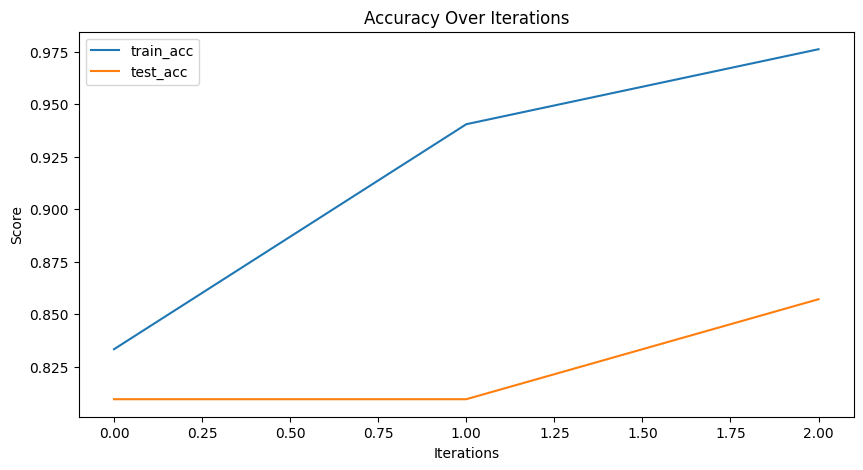

precision [0.89, 0.96, 0.98]
recall [0.83, 0.94, 0.98]
f1 [0.85, 0.95, 0.98]


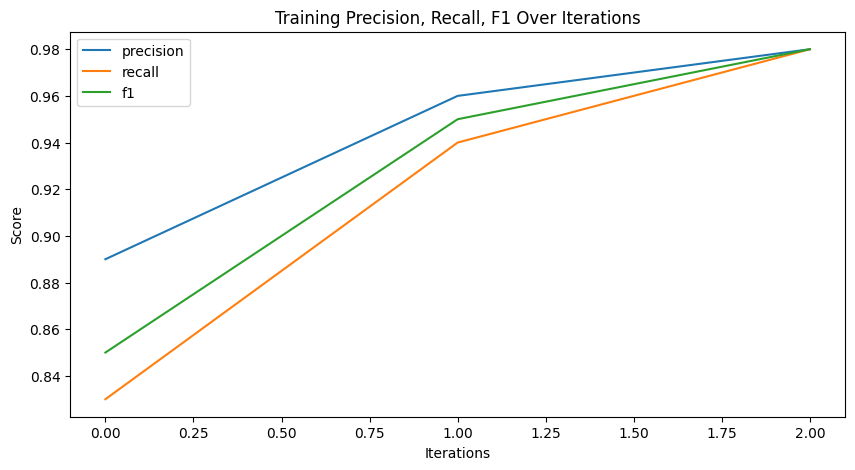

precision [0.91, 0.83, 0.87]
recall [0.81, 0.81, 0.86]
f1 [0.84, 0.81, 0.86]


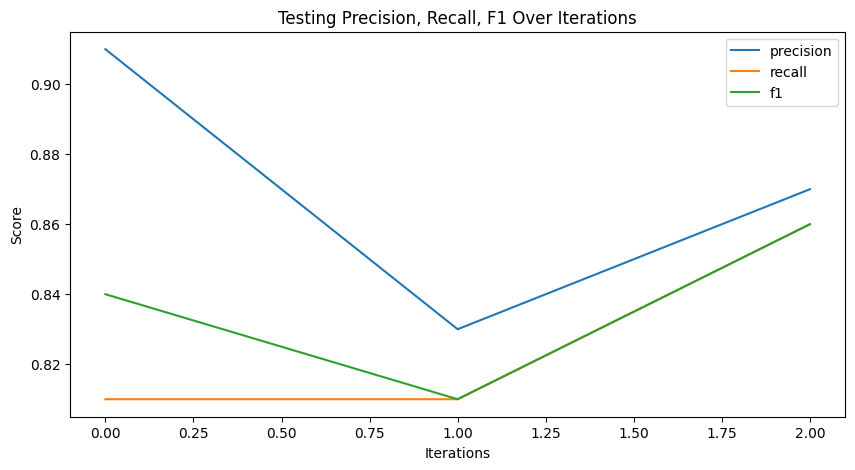

In [ ]:
# After the loop, plot the gathered metrics
plot_metrics({'train_acc': train_accs, 'test_acc': test_accs}, 'Accuracy Over Iterations')
plot_metrics(scores['train'], 'Training Precision, Recall, F1 Over Iterations')
plot_metrics(scores['test'], 'Testing Precision, Recall, F1 Over Iterations')

In [ ]:
output_model_file = 'pytorch_roberta_emotion_email.bin'
output_vocab_file = './'

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('All files saved')
print('This tutorial is completed')